In [1]:
try:
    import google.colab  # noqa: F401

    # specify the version of DataEval (==X.XX.X) for versions other than the latest
    %pip install -q dataeval
except Exception:
    pass

In [2]:
import torch

# Data structures
from dataeval.data import Embeddings, Images

# Coverage
from dataeval.metrics.bias import coverage

# Clustering
from dataeval.metrics.estimators import clusterer

# Dataset and model
from dataeval.utils.datasets import VOCDetectionTorch
from dataeval.utils.torch.models import ResNet18

# Set default torch device for notebook
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [3]:
resnet = ResNet18()

# Uncomment the line below to see the model architecture in detail
# print(resnet)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/dataeval/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [4]:
# Load the training dataset
dataset = VOCDetectionTorch(root="./data", year="2011", image_set="train", download=True)

print(dataset)

dataset[0][0].shape

VOCDetectionTorch Dataset
-------------------------
    Year: 2011
    Transforms: []
    Image_set: train
    Metadata: {'id': 'VOCDetectionTorch_train', 'index2label': {0: 'aeroplane', 1: 'bicycle', 2: 'bird', 3: 'boat', 4: 'bottle', 5: 'bus', 6: 'car', 7: 'cat', 8: 'chair', 9: 'cow', 10: 'diningtable', 11: 'dog', 12: 'horse', 13: 'motorbike', 14: 'person', 15: 'pottedplant', 16: 'sheep', 17: 'sofa', 18: 'train', 19: 'tvmonitor'}, 'split': 'train'}
    Path: /dataeval/docs/source/notebooks/data/vocdataset/TrainVal/VOCdevkit/VOC2011
    Size: 5717


torch.Size([3, 442, 500])

In [5]:
# Extract embeddings from the dataset using the ResNet18 model after applying transforms
embeddings = Embeddings(
    dataset=dataset,
    batch_size=64,
    model=resnet,
    transforms=resnet.transforms(),
).to_tensor()

embeddings.shape

torch.Size([5717, 128])

In [6]:
print(f"Max value: {embeddings.max()}")
print(f"Min value: {embeddings.min()}")

Max value: 3.5893452167510986
Min value: -3.3399722576141357


In [7]:
# Puts the embeddings onto the unit interval [0-1]
normalized_embs = (embeddings - embeddings.min()) / (embeddings.max() - embeddings.min())

print(f"Max value: {normalized_embs.max()}")
print(f"Min value: {normalized_embs.min()}")

Max value: 1.0
Min value: 0.0


In [8]:
output = clusterer(normalized_embs)

In [9]:
outliers = output.find_outliers()

print(f"Number of outliers: {len(outliers)}")

Number of outliers: 3581


In [10]:
print(f"Percent of outliers: {(100 * len(outliers) / len(dataset)):.2f}%")

Percent of outliers: 62.64%


In [11]:
# To use the flagged outliers, uncomment the line below
indices = outliers

# To use unflagged images, uncomment the line below
# indices = list(set(range(len(dataset))) - set(outliers)

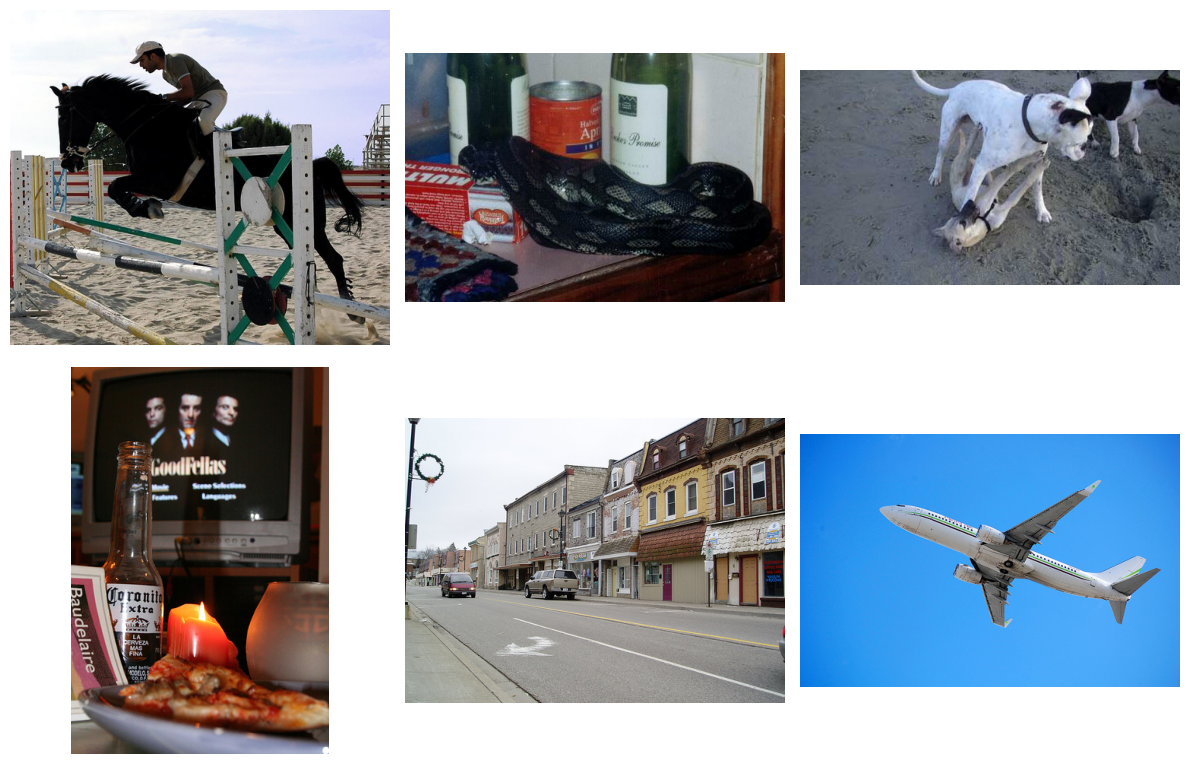

In [12]:
# Use the Images class to access and plot images
images = Images(dataset)

# Plot 6 images from the dataset
_ = images.plot(indices.tolist()[:6], figsize=(12, 8), images_per_row=3)

In [13]:
cov = coverage(embeddings=normalized_embs)

print(f"Number of uncovered images: {len(cov.uncovered_indices)}")

Number of uncovered images: 57


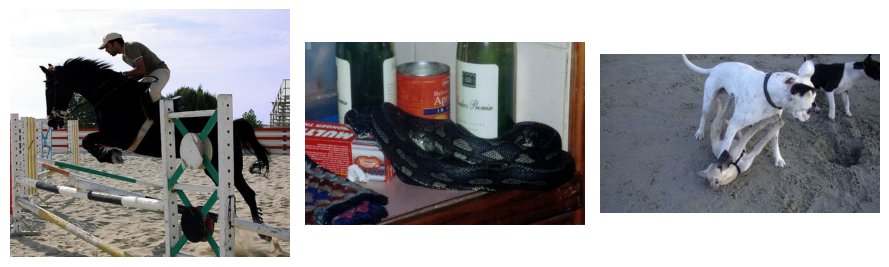

In [14]:
_ = cov.plot(images=images, top_k=3)

In [15]:
uncovered_outliers = set(cov.uncovered_indices.tolist()).intersection(set(outliers))

print(f"Number of outliers found as uncovered images: {len(uncovered_outliers)}")

Number of outliers found as uncovered images: 57
